In [1]:
# Import the Hudson and Thames MlFinLab package
import mlfinlab as ml
import numpy as np
import pandas as pd
import pyfolio as pf
import timeit

from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt


import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
%matplotlib inline

C:\Users\fdfpy\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
C:\Users\fdfpy\anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [2]:
def get_vol(prices, span=100, delta=pd.Timedelta(hours=1)):
  # 1. compute returns of the form p[t]/p[t-1] - 1
  # 1.1 find the timestamps of p[t-1] values
    
  df0 = prices.index.searchsorted(prices.index - delta) #price.index-deltaを計算する。それをもとのprice.index配列に順序を守り挿入するにはどこに挿入すればいいかを計算している。

  df0 = df0[df0 > 0]

  # 1.2 align timestamps of p[t-1] to timestamps of p[t]
  df0 = pd.Series(prices.index[df0-1],    
           index=prices.index[prices.shape[0]-df0.shape[0] : ])

  # 1.3 get values by timestamps, then compute returns
  df0 = prices.loc[df0.index] / prices.loc[df0.values].values - 1
    

  # 2. estimate rolling standard deviation
  df0 = df0.ewm(span=span).std()

    
  return df0


#price.index(時刻)+15分を計算し、もともと存在するprice.indexの最も近いものを見つける。
def get_horizons(prices, delta=pd.Timedelta(minutes=15)):
    t1 = prices.index.searchsorted(prices.index + delta)
    t1 = t1[t1 < prices.shape[0]]
    t1 = prices.index[t1]
    t1 = pd.Series(t1, index=prices.index[:t1.shape[0]])
    return t1



def get_touches(prices, events, factors=[1, 1]):
  '''
  events: pd dataframe with columns
    t1: timestamp of the next horizon
    threshold: unit height of top and bottom barriers
    side: the side of each bet
  factors: multipliers of the threshold to set the height of 
           top/bottom barriers
  '''
  out = events[['t1']].copy(deep=True)
  if factors[0] > 0: thresh_uppr = factors[0] * events['threshold']
  else: thresh_uppr = pd.Series(index=events.index) # no uppr thresh
  if factors[1] > 0: thresh_lwr = -factors[1] * events['threshold']
  else: thresh_lwr = pd.Series(index=events.index)  # no lwr thresh
  for loc, t1 in events['t1'].iteritems():
    df0=prices[loc:t1]                              # path prices
    df0=(df0 / prices[loc] - 1) * events.side[loc]  # path returns
    out.loc[loc, 'stop_loss'] = \
      df0[df0 < thresh_lwr[loc]].index.min()  # earliest stop loss
    out.loc[loc, 'take_profit'] = \
      df0[df0 > thresh_uppr[loc]].index.min() # earliest take profit
  return out

def get_labels(touches):
  out = touches.copy(deep=True)
  # pandas df.min() ignores NaN values
  first_touch = touches[['stop_loss', 'take_profit']].min(axis=1)
  for loc, t in first_touch.iteritems():
    if pd.isnull(t):
      out.loc[loc, 'label'] = 0
    elif t == touches.loc[loc, 'stop_loss']: 
      out.loc[loc, 'label'] = -1
    else:
      out.loc[loc, 'label'] = 1
  return out


def true_binary_label(y_pred, y_test):
    bin_label = np.zeros_like(y_pred)   #numpy.ndarray型y_predと同じサイズnumpy.ndarrayを用意しすべて配列の要素を0にする
    for i in range(y_pred.shape[0]):
        if y_pred[i] != 0 and y_pred[i]*y_test[i] > 0: #y_pred[i]==1 かつ y_test[i]==1の意味 or y_pred[i]==-1 かつ y_test[i]==-1の意味
            bin_label[i] = 1  # true positive
    return bin_label

X_train_count 4864
y_train_count 4864
1 of y_train 619
0 of y_train 3413
1 of y_train_res 3413
0 of y_train_res 3413
[1st model] train data for cm
[[3413 4801]
 [   0 2025]]
              precision    recall  f1-score   support

         0.0       1.00      0.63      0.78      8214
         1.0       0.40      1.00      0.57      2025

    accuracy                           0.71     10239
   macro avg       0.70      0.82      0.68     10239
weighted avg       0.88      0.71      0.74     10239

accuracy: 0.7065143080378943


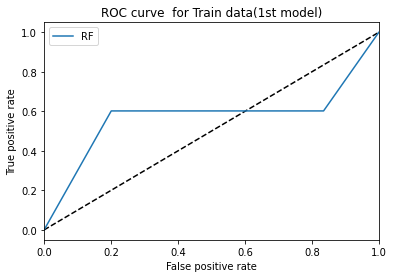

[1st model] test data for cm
[[730 399]
 [  0  87]]
              precision    recall  f1-score   support

         0.0       1.00      0.65      0.79      1129
         1.0       0.18      1.00      0.30        87

    accuracy                           0.67      1216
   macro avg       0.59      0.82      0.54      1216
weighted avg       0.94      0.67      0.75      1216

accuracy: 0.671875


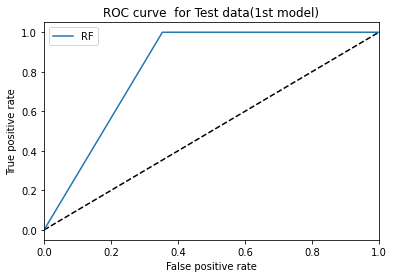

[2nd model] train data for cm
[[4435  886]
 [   0 3549]]
              precision    recall  f1-score   support

         0.0       1.00      0.83      0.91      5321
         1.0       0.80      1.00      0.89      3549

    accuracy                           0.90      8870
   macro avg       0.90      0.92      0.90      8870
weighted avg       0.92      0.90      0.90      8870

accuracy: 0.9001127395715897


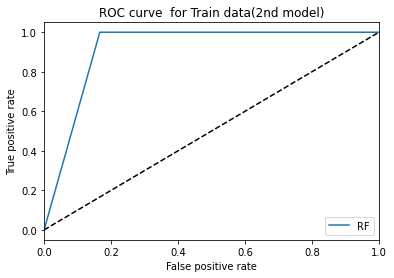

[2nd model] test data for cm
              precision    recall  f1-score   support

         0.0       1.00      0.79      0.88      1170
         1.0       0.16      1.00      0.27        46

    accuracy                           0.80      1216
   macro avg       0.58      0.89      0.58      1216
weighted avg       0.97      0.80      0.86      1216

[[921 249]
 [  0  46]]
accuracy: 0.7952302631578947


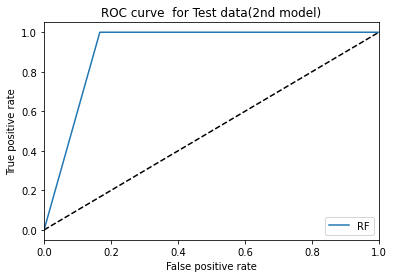

In [3]:
##【STEP1】 機械学習に使用するデータを整理する。


data_ohlc = pd.read_parquet('data_dollar_ohlc.pq')
#print('data_ohlc1',data_ohlc)

#data_ohdlに新しい列「threshold」を作り、get_vol(data_ohlc.close)の計算結果を配置(assign)する。
data_ohlc = data_ohlc.assign(threshold=get_vol(data_ohlc.close)).dropna()

#price.index(時刻)+15分を計算し、もともと存在するprice.indexの最も近いものを見つける。
data_ohlc = data_ohlc.assign(t1=get_horizons(data_ohlc)).dropna()

#列名「t1」と「threshold」をもつDataFrame eventsを用意する。
events = data_ohlc[['t1', 'threshold']] 
#DataFrame eventsに対し、列「side」を用意し、すべての要素の値を1にする。
events = events.assign(side=pd.Series(1., events.index)) # long only

#トリプルバリアの範囲を定義し、価格がトリプルバリアの上限または下限に初めて触れた時刻を取得する。
touches = get_touches(data_ohlc.close, events, [1,1])

#価格がトリプルバリアの上限に触れた-> label=1とする。
#価格がトリプルバリアの下限に触れた-> label=-1とする。
#価格がトリプルバリア上限、下限に触れず時間切れになった-> label=0とする。
touches = get_labels(touches)

#data_ohlcに上記で算出したlabel列を新規に追加、挿入する。
data_ohlc = data_ohlc.assign(label=touches.label)



##【STEP2】 data_ohlcを訓練データとテストデータに分割する。

X = data_ohlc[['open', 'close', 'high', 'low', 'vwap']].values
y = np.squeeze(data_ohlc[['label']].values) #np.squeeze　無駄な多次元配列を1次元配列に変換する。

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("X_train_count" ,X_train.shape[0])
print("y_train_count",y_train.shape[0])
print("1 of y_train" ,np.count_nonzero(y_train==1))
print("0 of y_train" ,np.count_nonzero(y_train==0))


##【STEP3】 訓練データy_trainの0,1が不均衡になっているので、疑似データを作り均衡化させる。

# Upsample the training data to have a 50 - 50 split
#0,1の個数が不均衡の場合は、均衡化させないとまともな機械学習ができない。
# https://elitedatascience.com/imbalanced-classes

sm = SMOTE()
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
print("1 of y_train_res" ,np.count_nonzero(y_train_res==1))
print("0 of y_train_res" ,np.count_nonzero(y_train_res==0))


##【STEP4-1】 primary model(ロジスティック回帰モデル)を構築する。

clf = LogisticRegression().fit(X_train_res, y_train_res)
y_train_pred = clf.predict(X_train_res)



##【STEP4-2】 訓練データの混合行列を計算する。

cm= confusion_matrix(true_binary_label(y_train_pred, y_train_res),  y_train_res != 0)
print('[1st model] train data for cm')
print(cm) #混合行列を計算する。
print(classification_report(true_binary_label(y_train_pred, y_train_res), y_train_pred != 0)) #classfication_reportを表示させる。
print('accuracy:',accuracy_score(true_binary_label(y_train_pred, y_train_res), y_train_pred != 0))

##【STEP4-3】 訓練データのROC曲線を描く。

fpr_rf, tpr_rf, _ = roc_curve(true_binary_label(y_train_pred, y_train_res), y_train_pred)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve  for Train data(1st model)')
plt.legend(loc='best')
plt.xlim(0,1)
plt.show()


##【STEP4-4】 テストデータの混合行列を計算する。

### y_pred != 0 の意味 ・・・予測
# y_pred[i]=0 -> FALSE , 
# y_pred[i]=1 ならば TRUE , y_pred[i]=-1　ならば TRUEを出力する

### true_binary_label(y_pred, y_test)の働き　・・・いいかえると株価上昇と予測→実際に株価上昇 or 株価下落と予測→実際に株価下落　どちらもgainを出せる。
#y_pred[i]==1 かつ y_test[i]==1の意味であれば1を返す。
#y_pred[i]==-1 かつ y_test[i]==-1の意味であれば1を返す。
#その他　0を返す。

y_pred = clf.predict(X_test)
cm= confusion_matrix(true_binary_label(y_pred, y_test), y_pred != 0)
print('[1st model] test data for cm')
print(cm) #混合行列を計算する。
print(classification_report(true_binary_label(y_pred, y_test), y_pred != 0)) #classfication_reportを表示させる。
print('accuracy:',accuracy_score(true_binary_label(y_pred, y_test), y_pred != 0))


##【STEP4-5】 テストデータのROC曲線を描く。

fpr_rf, tpr_rf, _ = roc_curve(true_binary_label(y_pred, y_test), y_pred != 0)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve  for Test data(1st model)')
plt.legend(loc='best')
plt.xlim(0,1)
plt.show()


##【STEP5】 2nd model(ロジスティック回帰モデル)を構築する。

# generate predictions for training set
y_train_pred = clf.predict(X_train) 

# add the predictions to features 
# np.hstack 配列を横（horizontal）に結合する関数。
# y_pred[:, None]　:   y_pred m個の要素をもつList。→ y_pred[:, None] m×1 のarray

X_train_meta = np.hstack([y_train_pred[:, None], X_train])
X_test_meta = np.hstack([y_pred[:, None], X_test])
# generate true meta-labels
y_train_meta = true_binary_label(y_train_pred, y_train)
# rebalance classes again
sm = SMOTE()
X_train_meta_res, y_train_meta_res = sm.fit_sample(X_train_meta, y_train_meta)
model_secondary = LogisticRegression().fit(X_train_meta_res, y_train_meta_res)

y_train_pred_res = model_secondary.predict(X_train_meta_res)


##【STEP5-1】 訓練データの混合行列(2nd model)を構築する。

cm= confusion_matrix(true_binary_label(y_train_pred_res, y_train_meta_res),  y_train_meta_res != 0)
print('[2nd model] train data for cm')
print(cm) #混合行列を計算する。
print(classification_report(true_binary_label(y_train_pred_res, y_train_meta_res), y_train_meta_res != 0)) #classfication_reportを表示させる。
print('accuracy:',accuracy_score(true_binary_label(y_train_pred_res, y_train_meta_res), y_train_meta_res != 0))


##【STEP5-2】 訓練データ(2nd model)のROCを構築する。
fpr_rf, tpr_rf, _ = roc_curve(true_binary_label(y_train_pred_res, y_train_meta_res), y_train_meta_res != 0)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve  for Train data(2nd model)')
plt.legend(loc='best')
plt.xlim(0,1)
plt.show()

# print("1 of y_pred" ,np.count_nonzero(y_pred==1))
# print("0 of y_pred" ,np.count_nonzero(y_pred==0))
# print("-1 of y_pred" ,np.count_nonzero(y_pred==-1))


##【STEP5-3】 テストデータの混合行列(2nd model)を構築する。

y_pred_meta = model_secondary.predict(X_test_meta)
# use meta-predictions to filter primary predictions
# y_pred -> 1次モデルから導き出した予測値
# y_pred_met -> 2次モデルから導き出した予測値

### true_binary_label(y_pred, y_test)の働き　・・・いいかえると株価上昇と予測→実際に株価上昇 or 株価下落と予測→実際に株価下落　どちらもgainを出せる。
#y_pred[i]==1 かつ y_test[i]==1の意味であれば1を返す。
#y_pred[i]==-1 かつ y_test[i]==-1の意味であれば1を返す。
#その他　0を返す。

cm= confusion_matrix(true_binary_label(y_pred_meta, y_test), (1 * y_pred_meta) != 0)
print('[2nd model] test data for cm')
print(classification_report(true_binary_label(y_pred_meta, y_test), (1 * y_pred_meta) != 0))
print(cm)
print('accuracy:',accuracy_score(true_binary_label(y_pred_meta, y_test),y_pred_meta != 0))

##【STEP5-4】 テストデータ(2nd model)のROCを構築する。
fpr_rf, tpr_rf, _ = roc_curve(true_binary_label(y_train_pred_res, y_train_meta_res), y_train_meta_res != 0)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve  for Test data(2nd model)')
plt.legend(loc='best')
plt.xlim(0,1)
plt.show()



In [25]:
data_ohlc 

,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional,cmDollar,grpId,vwap,open,high,low,close,threshold,t1,label
timestamp,,,,,,,,,,,,,,,,,,,
2018-12-04 01:10:40.787689,XBTUSD,Buy,400,3852.0,ZeroPlusTick,8602980a-839a-4ce0-a11b-25c5c0d2b32a,10384400,0.103844,400.0,1.019487e+08,50.0,3851.204119,3850.0,3852.5,3849.5,3852.0,0.002980,2018-12-04 01:30:59.937654,0.0
2018-12-04 01:14:00.876062,XBTUSD,Buy,1000,3847.5,ZeroPlusTick,ed4c1400-2ded-d554-3081-689b24c0826d,25991000,0.259910,1000.0,1.039983e+08,51.0,3851.481761,3852.0,3855.0,3847.0,3847.5,0.002513,2018-12-04 01:30:59.937654,1.0
2018-12-04 01:16:27.850240,XBTUSD,Buy,12000,3857.0,PlusTick,5f14af67-4b84-5909-08df-fe1fd5067404,311124000,3.111240,12000.0,1.059980e+08,52.0,3853.966010,3847.0,3858.0,3847.0,3857.0,0.002189,2018-12-04 01:33:16.610192,0.0
2018-12-04 01:18:14.564663,XBTUSD,Sell,85,3859.0,ZeroMinusTick,ce3f66f6-0349-88be-76b4-c630edbcb1cc,2202605,0.022026,85.0,1.079761e+08,53.0,3860.547363,3857.0,3864.5,3856.5,3859.0,0.002303,2018-12-04 01:33:16.610192,0.0
2018-12-04 01:22:01.296072,XBTUSD,Buy,174,3860.0,ZeroPlusTick,a32eadf8-ce47-2057-2fd1-6748684c65d3,4507818,0.045078,174.0,1.099929e+08,54.0,3857.849017,3859.0,3860.0,3856.0,3860.0,0.002675,2018-12-04 01:39:40.601451,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-09 23:28:51.651464,XBTUSD,Buy,606,3549.0,ZeroPlusTick,b561fe3b-cb2a-c2cb-46fc-69d4a00501a2,17075262,0.170753,606.0,1.229199e+10,6145.0,3543.918012,3538.0,3549.0,3538.0,3549.0,0.008383,2018-12-09 23:50:03.768329,0.0
2018-12-09 23:29:55.918034,XBTUSD,Sell,2000,3546.0,MinusTick,869a855c-a0f1-94da-706c-e41a5dc5d1c2,56402000,0.564020,2000.0,1.229400e+10,6146.0,3548.109326,3549.0,3550.0,3545.0,3546.0,0.008400,2018-12-09 23:50:03.768329,0.0
2018-12-09 23:34:04.801450,XBTUSD,Sell,326,3540.5,ZeroMinusTick,93b5a60d-930d-b088-cfa1-e3176a2e36c9,9207870,0.092079,326.0,1.229600e+10,6147.0,3542.648078,3546.0,3546.5,3540.5,3540.5,0.008346,2018-12-09 23:50:03.768329,0.0


timestamp
2018-12-04 01:10:40.787689    3852.0
2018-12-04 01:14:00.876062    3847.5
2018-12-04 01:16:27.850240    3857.0
2018-12-04 01:18:14.564663    3859.0
2018-12-04 01:22:01.296072    3860.0
                               ...  
2018-12-09 23:28:51.651464    3549.0
2018-12-09 23:29:55.918034    3546.0
2018-12-09 23:34:04.801450    3540.5
2018-12-09 23:40:13.071705    3537.5
2018-12-09 23:42:52.320598    3537.5
Name: close, Length: 6080, dtype: float64


(737032.0, 737037.0)

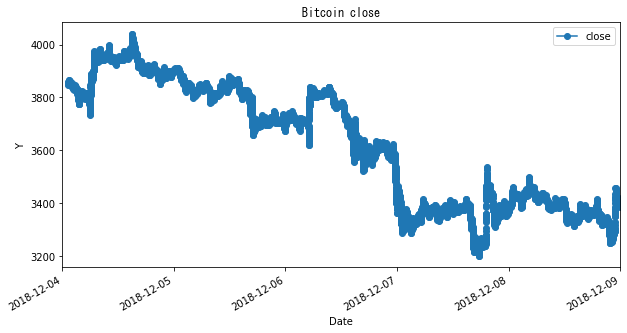

In [12]:
dat=data_ohlc.close
#dat['DATE'] = mdates.date2num(dat['DATE'])  #ここを追加する　Convert datetime objects to Matplotlib dates.
#dat.set_index("DATE",inplace=True) #横軸に表示する日付をDataFrameのindexにする。
print(dat)


fig = sns.mpl.pyplot.figure() #グラフを描写するオブジェクトを生成する。
ax=dat.plot(marker="o",figsize=(15, 5))
ax.legend() #凡例を描写する

# グラフのフォーマットの設定(横軸の日付の表示方法を設定する。)
days    = mdates.DayLocator(bymonthday=None, interval=1, tz=None)  # 横軸：「毎日」を表示対象にする。(この行がないと日付が重複表示される)
daysFmt = mdates.DateFormatter('%Y-%m-%d') #横軸：フォーマットをY-M-Dにする。
ax.xaxis.set_major_locator(days) #横軸に日付を表示する。
ax.xaxis.set_major_formatter(daysFmt) #横軸に日付を表示する。
fig.autofmt_xdate() #横軸の日付を見やすいように斜めにしてくれる。

# グラフに名前を付ける
ax.set_xlabel('Date') #X軸のタイトルを設定する
ax.set_ylabel('Y') #Y軸のタイトルを設定する
plt.title(r"Bitcoin close",fontname="MS Gothic")  #グラフのタイトルを設定する。日本語を指定するときは、fontnameの指定が必要
#グラフのサイズを設定する
fig.set_figheight(5)
fig.set_figwidth(10)
#横軸の表示範囲を設定する
ax.set_xlim(datetime.datetime(2018,12,4), datetime.datetime(2018,12,9))

timestamp
2018-12-04 02:14:38.341953         NaN
2018-12-04 02:18:48.702599    0.001737
2018-12-04 02:22:21.803131    0.002458
2018-12-04 02:24:24.204559    0.002077
2018-12-04 02:29:37.931981    0.001843
                                ...   
2018-12-09 23:28:51.651464    0.008383
2018-12-09 23:29:55.918034    0.008400
2018-12-09 23:34:04.801450    0.008346
2018-12-09 23:40:13.071705    0.008293
2018-12-09 23:42:52.320598    0.008241
Name: close, Length: 6059, dtype: float64


(737032.0, 737037.0)

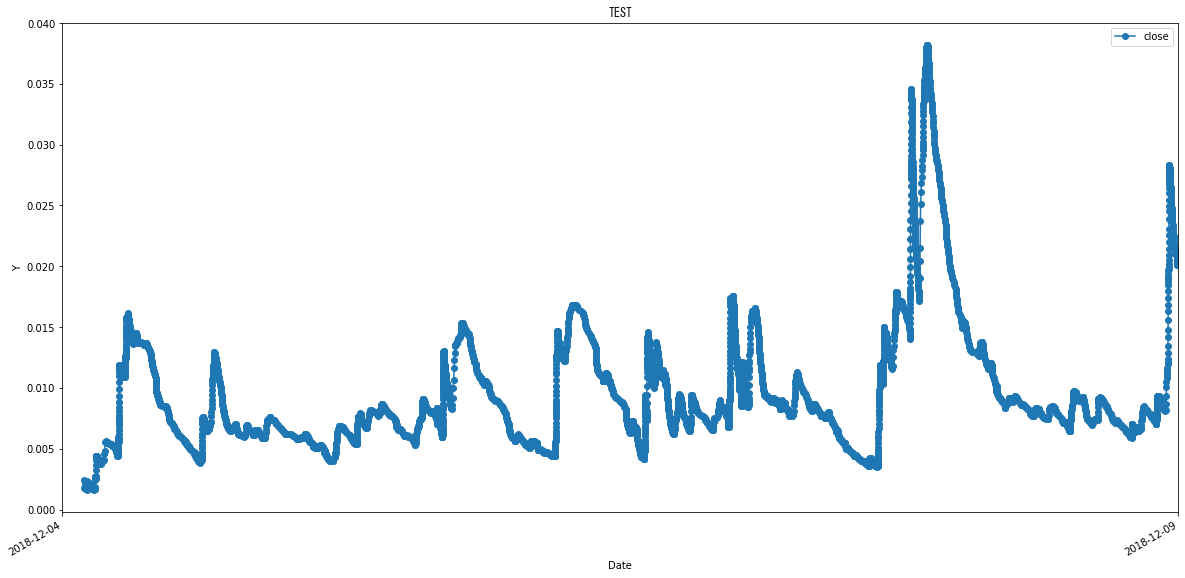

In [6]:
dat=get_vol(data_ohlc.close)
#dat['DATE'] = mdates.date2num(dat['DATE'])  #ここを追加する　Convert datetime objects to Matplotlib dates.
#dat.set_index("DATE",inplace=True) #横軸に表示する日付をDataFrameのindexにする。
print(dat)


fig = sns.mpl.pyplot.figure() #グラフを描写するオブジェクトを生成する。
ax=dat.plot(marker="o",figsize=(15, 5))
ax.legend() #凡例を描写する

# グラフのフォーマットの設定(横軸の日付の表示方法を設定する。)
days    = mdates.DayLocator(bymonthday=None, interval=30, tz=None)  # 横軸：「毎日」を表示対象にする。(この行がないと日付が重複表示される)
daysFmt = mdates.DateFormatter('%Y-%m-%d') #横軸：フォーマットをY-M-Dにする。
ax.xaxis.set_major_locator(days) #横軸に日付を表示する。
ax.xaxis.set_major_formatter(daysFmt) #横軸に日付を表示する。
fig.autofmt_xdate() #横軸の日付を見やすいように斜めにしてくれる。

# グラフに名前を付ける
ax.set_xlabel('Date') #X軸のタイトルを設定する
ax.set_ylabel('Y') #Y軸のタイトルを設定する
plt.title(r"TEST",fontname="MS Gothic")  #グラフのタイトルを設定する。日本語を指定するときは、fontnameの指定が必要
#グラフのサイズを設定する
fig.set_figheight(10)
fig.set_figwidth(20)
#横軸の表示範囲を設定する
ax.set_xlim(datetime.datetime(2018,12,4), datetime.datetime(2018,12,9))